# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблем, предоставляемым библиотекой CatBoost.

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score

# imports from other HWs
import nbimporter

from hw01 import read_cancer_dataset, read_spam_dataset, train_test_split
from hw03 import plot_roc_curve

Importing Jupyter notebook from hw01.ipynb
Importing Jupyter notebook from hw03.ipynb


### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [2]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.trees = [DecisionTreeClassifier(criterion, 
                                             max_depth=max_depth, 
                                             min_samples_leaf=min_samples_leaf, 
                                             max_features=max_features) 
                      for _ in range(n_estimators)]
    
    def fit(self, X, y):
        for tree in self.trees:
            tree.fit(X, y, np.random.poisson(size=len(y)))
    
    def predict_proba(self, X):
        return np.mean([tree.predict_proba(X) for tree in self.trees], axis=0)
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1).astype(int)

### Задание 3 (3 балла)
Оптимизируйте по AUC на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации Random Forest: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте ROC кривую (и выведите AUC и accuracy) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [3]:
def selection_of_hyperparameters(X, y):
    kf = KFold(n_splits=5, shuffle=True)
    
    best_mean_roc_auc = 0
    best_param = None
    
    for max_depth in [2, 3, 5, 7, 10]:
        for n_estimators in [5, 10, 20, 30, 50, 100]:
            roc_auc_scores = []
            rfc =  RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                rfc.fit(X_train, y_train)
                roc_auc_scores.append(roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]))
            if np.mean(roc_auc_scores) > best_mean_roc_auc:
                best_mean_roc_auc = np.mean(roc_auc_scores)
                best_param = dict(n_estimators=n_estimators, max_depth=max_depth)
                
    return best_param

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. 
Есть различные способы посчитать его важность. 
Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [4]:
def feature_importance(rfc, X, y):
    before = np.mean(rfc.predict(X) == y)
    result = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        X_tmp = np.copy(X)
        np.random.shuffle(X_tmp[:, i])
        result[i] = before - np.mean(rfc.predict(X_tmp) == y)
    return result / np.sum(result)

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. 
В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, 
признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [5]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)
X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(criterion="entropy", max_depth=100)
rfc.fit(X, y)

print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", feature_importance(rfc, X, y))

Accuracy: 1.0
Importance: [0.         0.         0.28588957 0.2809816  0.43312883 0.        ]


Проверьте, какие признаки важны для датасетов cancer и spam?

In [6]:
def cast_to_dict(probas):
    return dict((i, p) for i, p in enumerate(probas))

def get_features_names_from_file(file):
    with open(file) as f:
        l = f.readline()
    return l.split(',')[:-1]

## Cancer dataset

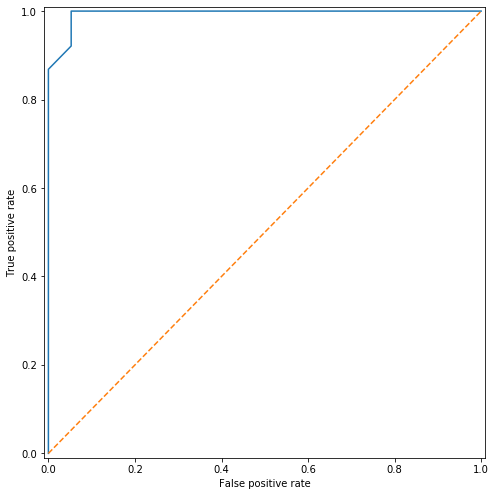

Most important features: ['7' '20' '21' '27' '22' '4' '13' '15' '5' '17' '8' '19' '10' '23' '3' '1'
 '6' '2' '29' '14']


In [7]:
cancer_file = 'data/cancer.csv'
X, y = read_cancer_dataset(cancer_file)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
best_params = selection_of_hyperparameters(X_train, y_train)

rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train, y_train)
probas = rfc.predict_proba(X_test)
plot_roc_curve(y_test, np.apply_along_axis(cast_to_dict, 1, probas))

importances = feature_importance(rfc, X, y)
names = get_features_names_from_file(cancer_file)
print('Most important features:', most_important_features(importances, names))

## Spam dataset



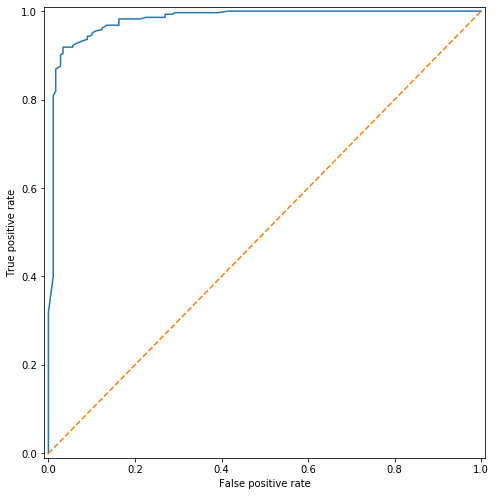

Most important features: ['char_freq_!' 'word_freq_remove' 'word_freq_free' 'char_freq_$'
 'word_freq_george' 'word_freq_hp' 'capital_run_length_average'
 'word_freq_your' 'word_freq_our' 'word_freq_you' 'word_freq_1999'
 'word_freq_edu' 'word_freq_money' 'capital_run_length_longest'
 'word_freq_business' 'word_freq_will' 'word_freq_all' 'char_freq_('
 'word_freq_hpl' 'word_freq_internet']


In [8]:
spam_file = 'data/spam.csv'
X, y = read_spam_dataset(spam_file)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
best_params = selection_of_hyperparameters(X_train, y_train)

rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train, y_train)
probas = rfc.predict_proba(X_test)
plot_roc_curve(y_test, np.apply_along_axis(cast_to_dict, 1, probas))

importances = feature_importance(rfc, X, y)
names = get_features_names_from_file(spam_file)
print('Most important features:', most_important_features(importances, names))

### Задание 5 (1 балл)
В качестве аьтернативы попробуем CatBoost. 

Туториалы можно найти, например, [здесь](https://catboost.ai/docs/) и [здесь](https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb).

Также, как и реализованный ними RandomForest, примените его для наших датасетов.


## Cancer dataset

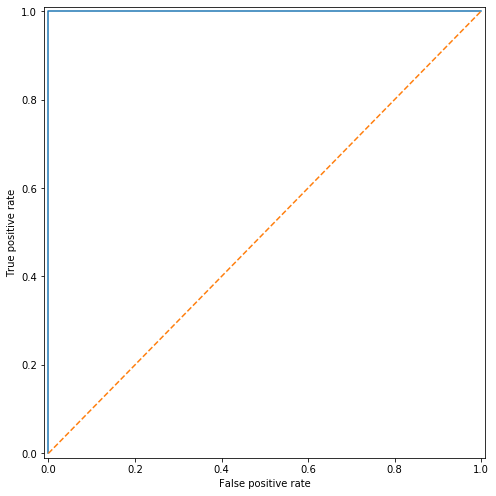

In [9]:
cancer_file = 'data/cancer.csv'
X, y = read_cancer_dataset(cancer_file)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

cls = CatBoostClassifier(silent=True)
cls.fit(X_train, y_train)
probas = cls.predict_proba(X_test)
plot_roc_curve(y_test, np.apply_along_axis(cast_to_dict, 1, probas))

## Spam dataset


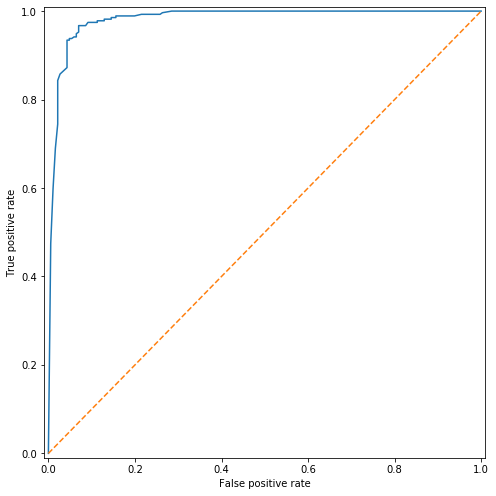

In [10]:
spam_file = 'data/spam.csv'
X, y = read_spam_dataset(spam_file)
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

cls = CatBoostClassifier(silent=True)
cls.fit(X_train, y_train)

probas = cls.predict_proba(X_test)
plot_roc_curve(y_test, np.apply_along_axis(cast_to_dict, 1, probas))